#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from math import sqrt

from sklearn.metrics import mean_squared_error, make_scorer


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit


plt.rcParams["figure.figsize"] = (8,6)

## Подготовка

Считаем и изучим имеющиеся данные

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.sample(10)

,num_orders
datetime,
2018-04-27 23:40:00,8
2018-04-29 16:20:00,29
2018-05-01 18:40:00,6
2018-05-18 00:30:00,11
2018-07-15 11:00:00,7
2018-08-19 10:30:00,11
2018-03-15 20:50:00,21
2018-07-09 21:00:00,19
2018-08-14 01:20:00,29


In [ ]:
#Проведем ресемплирование данных по одному часу
data = data.resample('1H').sum()

## Анализ

In [ ]:
#Изучим данные в датасете более детально
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [ ]:
#Изучим колличество пропусков
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
num_orders,0.000000


Проанализируем скользящее среднее выборки и распределение данных с помощью графика

In [ ]:
data1 = data.copy(deep=True)
data1['rolling_mean'] = data1['num_orders'].rolling(10).mean()

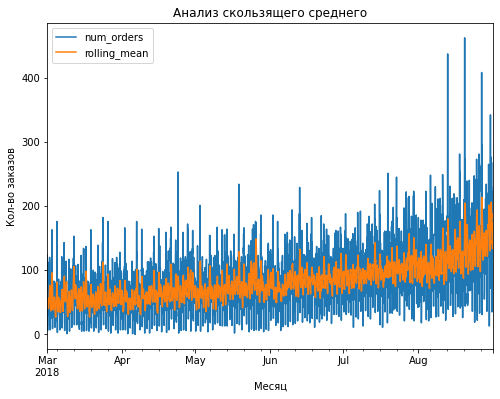

In [ ]:
data1.plot()

plt.title("Анализ скользящего среднего")
plt.xlabel("Месяц")
plt.ylabel("Кол-во заказов")

plt.show()

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4407 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 103.5 KB


Проведем декомпозицию, дабы проанализировать тренды и сезонность наших данных

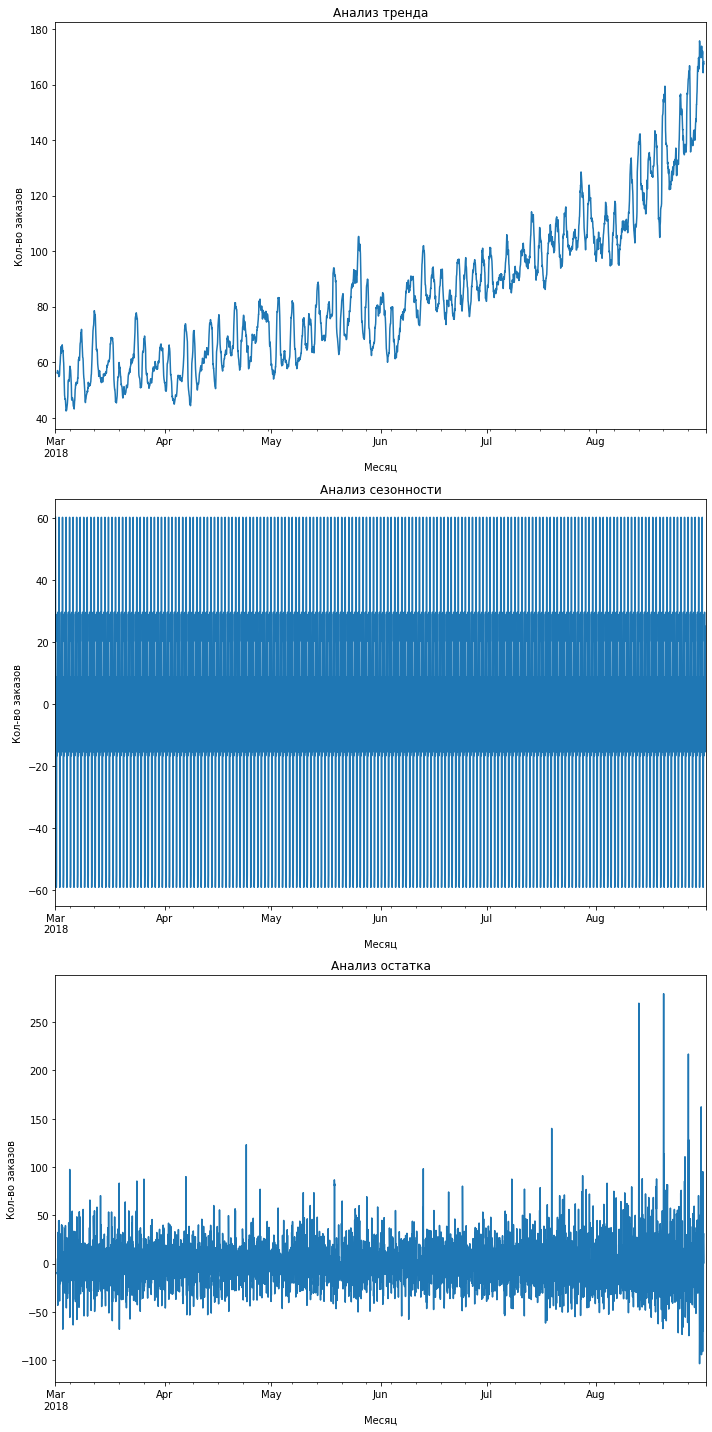

In [ ]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.title("Анализ тренда")
plt.xlabel("Месяц")
plt.ylabel("Кол-во заказов")
plt.subplot(312)
# < напишите код здесь >
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.title("Анализ сезонности")
plt.xlabel("Месяц")
plt.ylabel("Кол-во заказов")
plt.subplot(313)
# < напишите код здесь >
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.title("Анализ остатка")
plt.xlabel("Месяц")
plt.ylabel("Кол-во заказов")
plt.tight_layout()

Вывод:
- У нас в наличии представлены данные за 2018 год, с марта по август
- В данных отсутствуют пропуски
- Есть тренд на постепенный рост числа заказов такси c Марта по Август
- Наиболее резкий рост начинается в Августе
- Также в Августе присутвуют наибольшие выбросы с точки зрения роста числа заказов, особенно ближе к концу месяца

Дополнительно изучим сезонную компоненту наших данных для лушчего понимания природы сезонности, на более коротком промежутке времени, например- 2-3 суток.

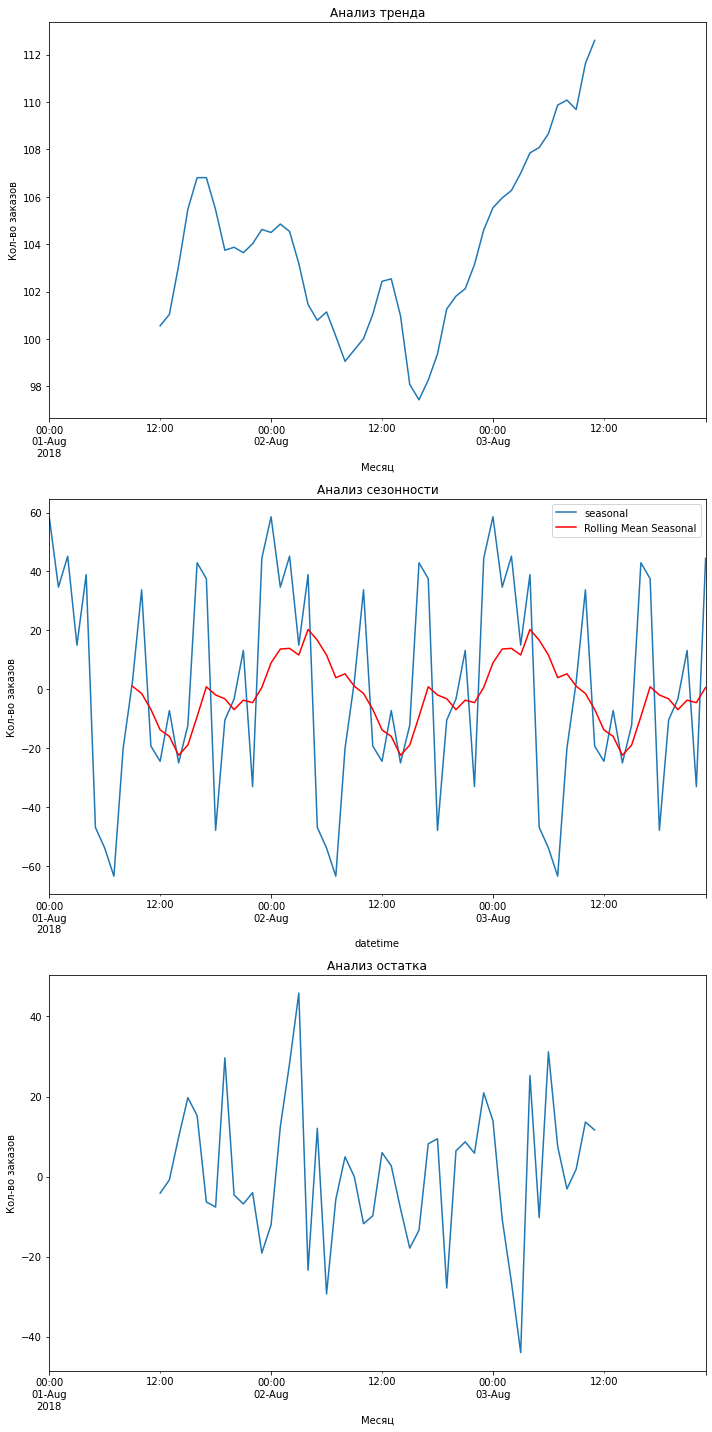

In [ ]:
decomposed = seasonal_decompose(data['2018-08-01':'2018-08-03'])

plt.figure(figsize=(10, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.title("Анализ тренда")
plt.xlabel("Месяц")
plt.ylabel("Кол-во заказов")
plt.subplot(312)
# < напишите код здесь >
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.title("Анализ сезонности")
plt.xlabel("Месяц")
plt.ylabel("Кол-во заказов")
rolling_mean_seasonal = decomposed.seasonal.rolling(window=10).mean()
rolling_mean_seasonal.plot(ax=plt.gca(), label='Rolling Mean Seasonal', color='red')
plt.legend()

plt.subplot(313)


# < напишите код здесь >
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.title("Анализ остатка")
plt.xlabel("Месяц")
plt.ylabel("Кол-во заказов")
plt.tight_layout()

Выводы:

- Cезонность имеет суточный характер, что мы можем видеть по графику выше

- Большая часть заказов происходит ночью и ранним утром, спад наблюдается в первой половине дня.

- Скорее всего, эти пики и спады, связаны с тем,что поскольку речь идет о заказе такси из аэропортов, данные графики связаны с граифком прилета самолетов, который может быть схожим для всех аэропортов. Также, большее количество заказов ночью может быть связано, с меньшей доступностью общественного транспорта в эти часы, из-за чего больше людей прибегают к услугам такси.

## Обучение

Создадим оценьщик RMSE для использования в обучении моделей c помощью GridSearch

In [ ]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Создадим функцию для создания дополнительных признаков в датасете

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data_mf = data.copy()
    data_mf['day'] = data_mf.index.day
    data_mf['dayofweek'] = data_mf.index.dayofweek

    for lag in range(1, max_lag + 1):
        data_mf['lag_{}'.format(lag)] = data_mf['num_orders'].shift(lag)

    data_mf['rolling_mean'] = data_mf['num_orders'].shift().rolling(rolling_mean_size).mean()

    data_mf.dropna(inplace= True)
    return data_mf

In [ ]:
data_new = make_features(data, 6, 7)

In [ ]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4409 entries, 2018-03-01 07:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4409 non-null   int64  
 1   day           4409 non-null   int64  
 2   dayofweek     4409 non-null   int64  
 3   lag_1         4409 non-null   float64
 4   lag_2         4409 non-null   float64
 5   lag_3         4409 non-null   float64
 6   lag_4         4409 non-null   float64
 7   lag_5         4409 non-null   float64
 8   lag_6         4409 non-null   float64
 9   rolling_mean  4409 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 378.9 KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 198.0 KB


Для подбора оптимального колличества отстающих значений и величины скользящего среднего, построим небольшой цикл ниже
В качестве модели предсказания, выберем Линейную регрессию, как наиболее простую и быструю в рамках перебора гиперпараметров

In [ ]:
# Создаем копию исходного датасета, для перебора гиперпараметров

best_rmse = float('inf')
best_max_lag = 0
best_rolling_mean_size = 0

for max_lag in range(3, 101):
    for rolling_mean_size in range(3, 101):
        data2 = make_features(data, max_lag, rolling_mean_size)

        # Разделим данные на тренировочную, валидационную и тестовую выборки
        X = data2.drop(['num_orders'], axis=1)
        y = data2['num_orders']
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
        X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=False)

        # Создаем и обучаем модель линейной регрессии
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Сделаем предсказания
        y_pred = model.predict(X_val)

        # Рассчитаем RMSE
        rmse = RMSE(y_val, y_pred)

        # Сравним RMSE с текущим лучшим результатом
        if rmse < best_rmse:
            best_rmse = rmse
            best_max_lag = max_lag
            best_rolling_mean_size = rolling_mean_size

print(f"Лучший RMSE: {best_rmse}")
print(f"Лучший max_lag: {best_max_lag}")
print(f"Лучший rolling_mean_size: {best_rolling_mean_size}")

Лучший RMSE: 29.995979662647528
Лучший max_lag: 96
Лучший rolling_mean_size: 100


Полученные, лучшие гиперпараметры, используем на нашем датасете и подберем лучшую модель путем перебора гиперпараметров через Grid Search

In [ ]:
data_train = make_features(data, 96, 100)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4316 entries, 2018-03-05 04:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 100 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4316 non-null   int64  
 1   day           4316 non-null   int64  
 2   dayofweek     4316 non-null   int64  
 3   lag_1         4316 non-null   float64
 4   lag_2         4316 non-null   float64
 5   lag_3         4316 non-null   float64
 6   lag_4         4316 non-null   float64
 7   lag_5         4316 non-null   float64
 8   lag_6         4316 non-null   float64
 9   lag_7         4316 non-null   float64
 10  lag_8         4316 non-null   float64
 11  lag_9         4316 non-null   float64
 12  lag_10        4316 non-null   float64
 13  lag_11        4316 non-null   float64
 14  lag_12        4316 non-null   float64
 15  lag_13        4316 non-null   float64
 16  lag_14        4316 non-null   float64
 17  lag_15        4316 non-nul

Проведем разделение полученного датасета на тренировочный и тестовый датасеты, перемешивание отключим в связи со спецификой предсказания данных на временном ряде

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    data_train.drop(['num_orders'], axis=1), data_train['num_orders'], shuffle=False, test_size=0.1)

Создадим константную модель предсказания результата медианой для сранвнения результатов предсказания на тренировочной выборке

In [ ]:
pred_median = np.ones(target_test.shape)*target_train.median()
RMSE1 = RMSE(target_test, pred_median)

print("RMSE:", RMSE1)

RMSE: 86.96936987409013


In [ ]:
# Зададим параметры валидатора TimeSeriesSplit, чтобы использовать его в кросс валидации, при подборе наилучших гиперпараметров в моделях ниже и избежать перемешивания данных, как при обычной кросс валидации
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# 1. Модель Linear Regression

lr_model = LinearRegression()
param_grid_lr = {}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, scoring=RMSE_score, cv=tscv)

grid_search_lr.fit(features_train, target_train)

best_lr_model = grid_search_lr.best_estimator_

LinearRegression_result = grid_search_lr.best_params_, grid_search_lr.best_score_

# Выведем наилучшие параметры и оценку каждой модели
print("LinearRegression - Лучшие параметры:", grid_search_lr.best_params_)
print("LinearRegression - Наилучшая оценка:", -grid_search_lr.best_score_)

LinearRegression - Лучшие параметры: {}
LinearRegression - Наилучшая оценка: 23.93523015584729


In [ ]:
# 2. Модель Decision Trees
tscv = TimeSeriesSplit(n_splits=5)

dt_model = DecisionTreeRegressor(random_state=0)

param_grid_dt = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, scoring=RMSE_score, cv=tscv)
grid_search_dt.fit(features_train, target_train)

best_dt_model = grid_search_dt.best_estimator_
DecisionTreeRegressor_result = grid_search_dt.best_params_, grid_search_dt.best_score_

print("DecisionTreeRegressor - Лучшие параметры:", grid_search_dt.best_params_)
print("DecisionTreeRegressor - Наилучшая оценка:", -grid_search_dt.best_score_)

DecisionTreeRegressor - Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeRegressor - Наилучшая оценка: 28.668578995978116


In [ ]:
# 3. Модель Random Forest
rf_model = RandomForestRegressor(random_state=0)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring=RMSE_score, cv=tscv)
grid_search_rf.fit(features_train, target_train)

best_rf_model = grid_search_rf.best_estimator_
RandomForestRegressor_result = grid_search_rf.best_params_, grid_search_rf.best_score_

print("RandomForestRegressor - Лучшие параметры:", grid_search_rf.best_params_)
print("RandomForestRegressor - Наилучшая оценка:", -grid_search_rf.best_score_)

RandomForestRegressor - Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
RandomForestRegressor - Наилучшая оценка: 24.314854790602674


In [ ]:
# 4. Модель CatBoost
catboost_model = CatBoostRegressor(random_state=0, silent= True)

param_grid_catboost = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 500, 1000]
}

grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid_catboost, scoring=RMSE_score, cv=tscv)
grid_search_catboost.fit(features_train, target_train)

best_catboost_model = grid_search_catboost.best_estimator_
CatBoostRegressor_result = grid_search_catboost.best_params_, grid_search_catboost.best_score_


In [ ]:
LinearRegression_result = grid_search_lr.best_params_, -grid_search_lr.best_score_
DecisionTreeRegressor_result = grid_search_dt.best_params_, -grid_search_dt.best_score_
CatBoostRegressor_result = grid_search_catboost.best_params_, -grid_search_catboost.best_score_
RandomForestRegressor_result = grid_search_rf.best_params_, -grid_search_rf.best_score_

# Выведем наилучшие параметры и оценку каждой модели
print("LinearRegression - Лучшие параметры:", grid_search_lr.best_params_)
print("LinearRegression - Наилучшая оценка:", -grid_search_lr.best_score_)
print("DecisionTreeRegressor - Лучшие параметры:", grid_search_dt.best_params_)
print("DecisionTreeRegressor - Наилучшая оценка:", -grid_search_dt.best_score_)
print("CatBoostRegressor - Лучшие параметры:", grid_search_catboost.best_params_)
print("CatBoostRegressor - Наилучшая оценка:", -grid_search_catboost.best_score_)
print("RandomForestRegressor - Лучшие параметры:", grid_search_rf.best_params_)
print("RandomForestRegressor - Наилучшая оценка:", -grid_search_rf.best_score_)

LinearRegression - Лучшие параметры: {}
LinearRegression - Наилучшая оценка: 23.93523015584729
DecisionTreeRegressor - Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
DecisionTreeRegressor - Наилучшая оценка: 28.668578995978116
CatBoostRegressor - Лучшие параметры: {'depth': 4, 'iterations': 100, 'learning_rate': 0.01}
CatBoostRegressor - Наилучшая оценка: 30.981470055236507
RandomForestRegressor - Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
RandomForestRegressor - Наилучшая оценка: 24.314854790602674


И составим таблицу с информацией по гиперпараметрам и оценке RMSE для более тщательного анализа данных

In [ ]:
display(pd.DataFrame([LinearRegression_result, DecisionTreeRegressor_result, CatBoostRegressor_result, RandomForestRegressor_result],
             columns=['Гиперпараметры', 'RMSE'],
                      index=['LinearRegression','DecisionTreeRegressor', 'CatBoostRegressor', 'RandomForestRegressor']))

,Гиперпараметры,RMSE
LinearRegression,{},23.935230
DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",28.668579
CatBoostRegressor,"{'depth': 4, 'iterations': 100, 'learning_rate...",30.981470
RandomForestRegressor,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",24.314855


Наилучший результат, показала модель линейной регрессии, используем ее для дальнейшей работы и обучения модели.

## Тестирование

Проверим лучшую из полученных моделей с наилучшими гиперпараметрами функции make features на тестовом датасете

In [ ]:
model = LinearRegression()
model.fit(features_train, target_train)

# Сделаем предсказания на тестовом датасете
features_pred = model.predict(features_test)

# Рассчитаем RMSE
rmse = RMSE(target_test, features_pred)
print(rmse)

40.161633976109655


Изучим и сравним результаты предсказания на тестовой выборке с фактическими результатами на

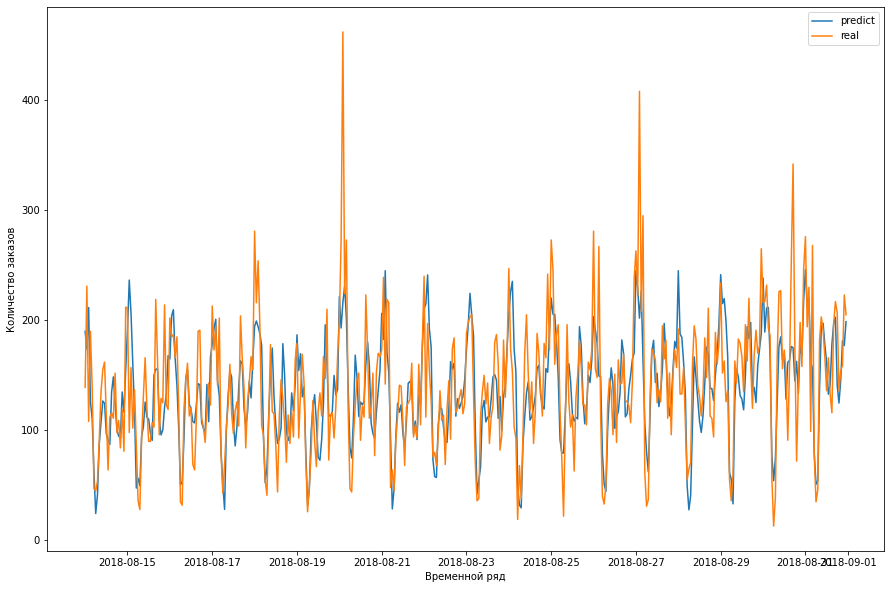

In [ ]:
features_pred_line = pd.Series(features_pred, index=target_test.index)
plt.figure(figsize=(15, 10))
plt.rc('font', size=10) #размер текста
plt.plot(features_pred_line, label='predict')
plt.plot(target_test, label='real')
plt.xlabel('Временной ряд')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

<Figure size 4320x2880 with 0 Axes>

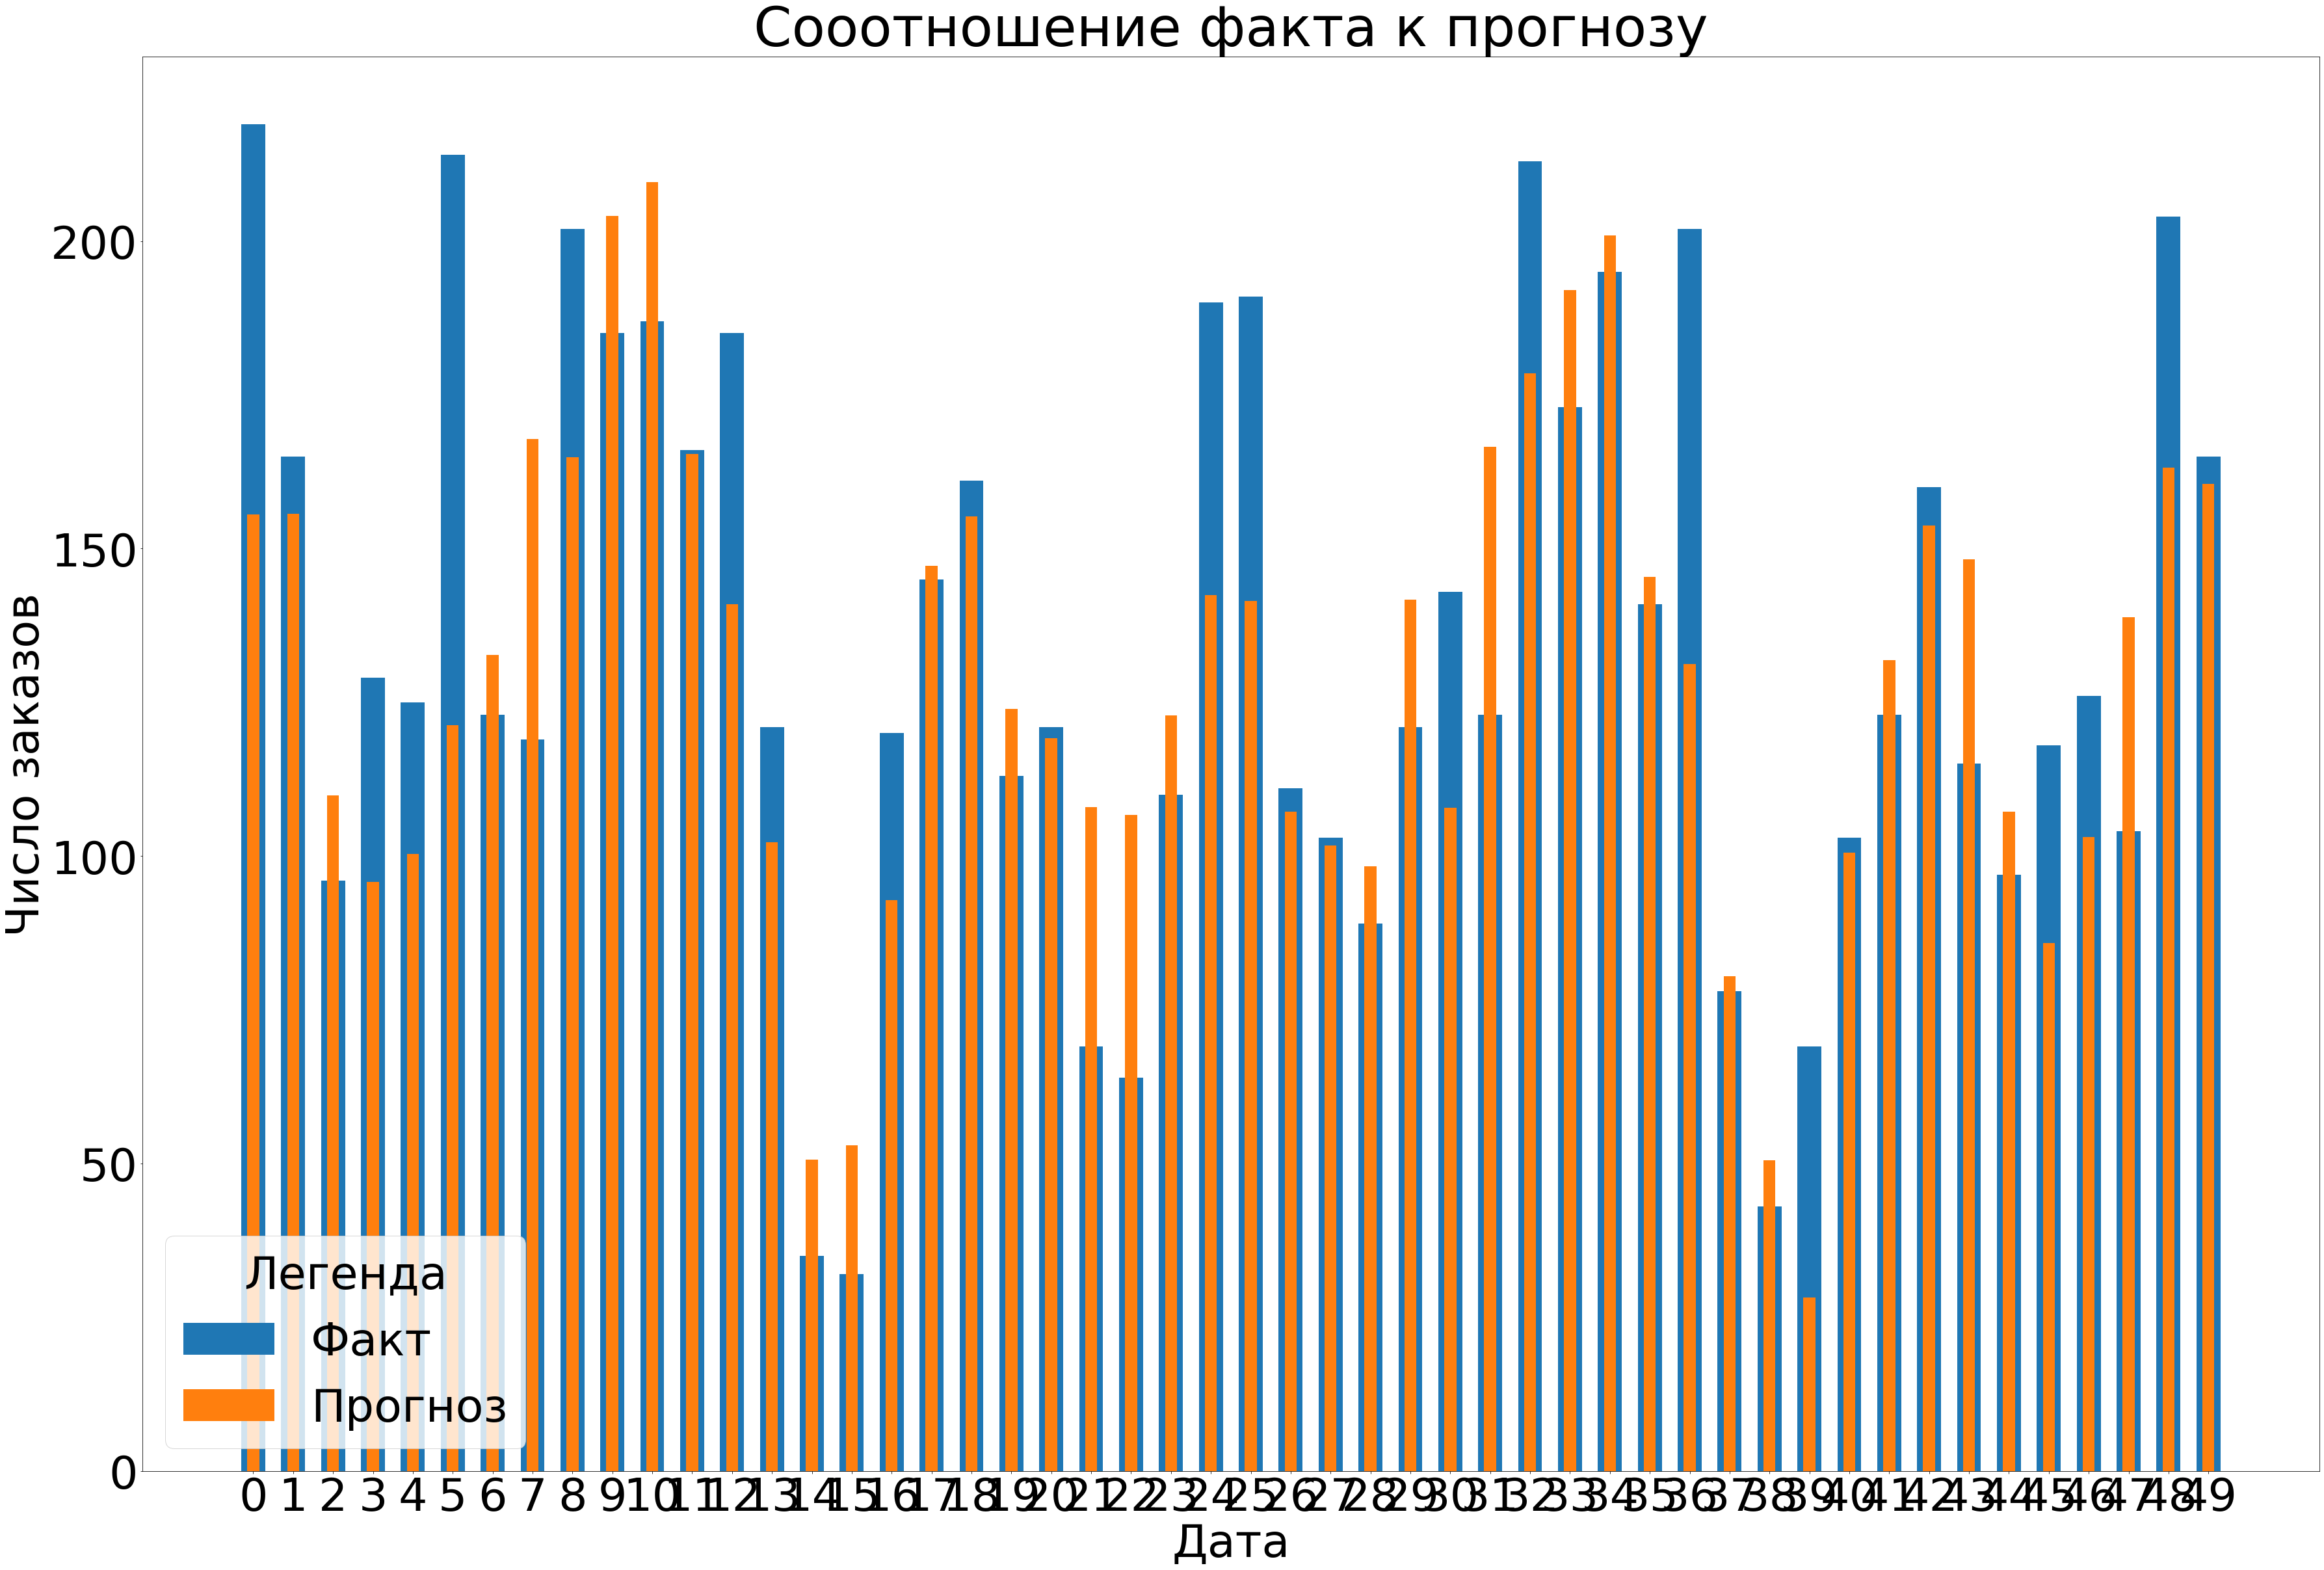

In [ ]:
fig = plt.figure()
fig.set_size_inches(60, 40)

fig,ax = plt.subplots()
fig.set_size_inches(60,40)

plt.rc('font', size=70) #controls default text size

у1 = features_pred[40:90]
y2 = target_test[40:90]
x = np.arange(len(у1))

ax.set_xticks(x)
fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
forecast = ax.bar(x, у1, width = 0.3, label = 'Прогноз')

ax.set_ylabel('Число заказов')
ax.set_xlabel('Дата')
ax.set_title('Сооотношение факта к прогнозу')
ax.legend(loc='lower left', title='Легенда')

plt.plot();

Вывод:

- Лучший результат показала модель- Логистической регрессии с метрикой RMSE на тестовом датасете в- 41

- Интересно, что наибольший прирост для качества модели на тестовой выборке, принесли именно гиперпараметры функции make_features, при создании, новых признаков, нежели перебор гиперпарамтеров или сравнение различных моделей

- Из этого, можно сделать вывод, что наибольший прирост при прогнозировании в задачах временного ряда, дает именно число синтетических признаков датасета, нежели перебор гиперпараметров или выбор модели